# Análisis de Componentes Principales (PCA)

Lo primero que realizamos es importar las librerías necesarias, definir algunas constantes y cargar el dataset.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.utils import Utils

COLORS = ["#003049", "#d62828", "#f77f00", "#fcbf49", "#eae2b7", "#007F83", "#BC3C28", "#FFD56B", "#006A4E"]

DATASET_PATH = os.path.join("resources", "europe.csv")
dataset = pd.read_csv(DATASET_PATH)

## Análisis de las variables (boxplot)

Primero, definimos una función para graficar los boxplots de las variables.

In [27]:
def show_boxplot(dataset):
    fig, ax = plt.subplots()

    boxplot = ax.boxplot(dataset.select_dtypes(include='number').values, patch_artist=True, medianprops=dict(color="white"))

    for patch, color in zip(boxplot['boxes'], COLORS):
        patch.set_facecolor(color)

    ax.set_xticklabels(dataset.columns[1:], rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

Veamos los boxplots de las variables sin ninguna estandarización.

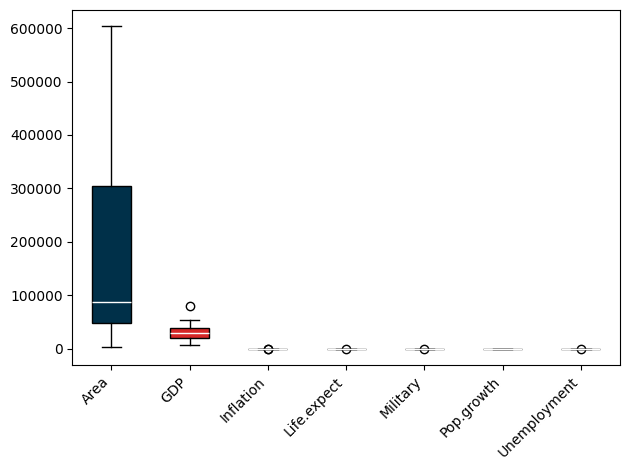

In [28]:
show_boxplot(dataset)

Como se puede apreciar, al no estar los datos estandarizados, la variable "Area" de los países es la predominante y, debido a su magnitud, no deja ver las demás variables.

Se aplica el método z-score para estandarizar los datos, y se obtiene lo siguiente:

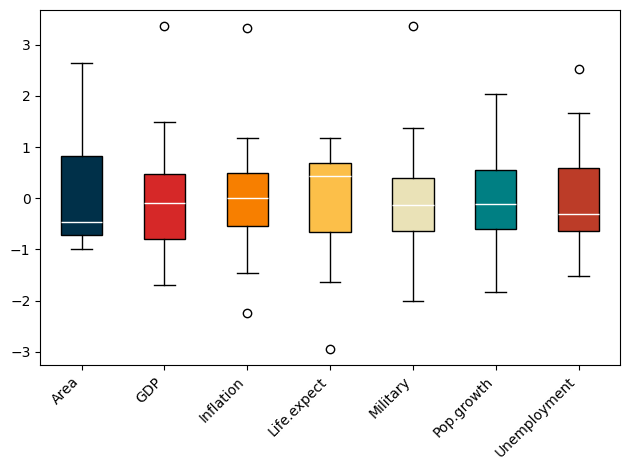

In [29]:
standarizedDataset = Utils.zScoreData(dataset)
show_boxplot(standarizedDataset)

## Análisis de Componentes Principales (PCA)

Para realizar el análisis de componentes principales, se calcula la matriz de correlaciones en lugar de la matriz de covarianzas, proque los datos ya están estandarizados:

In [31]:
sx = np.corrcoef(standarizedDataset.select_dtypes(include='number').values, rowvar=False)

A partir de esta matriz, se calculan los autovalores ordenados descendentemente:

In [33]:
evalues, evectors = np.linalg.eig(sx) 
indices = np.argsort(evalues)[::-1]
sortedEvalues = evalues[indices]
sortedEvectors = evectors[:, indices]

print("Autovalores: ", sortedEvalues)

Autovalores:  [3.22716568 1.18712341 1.06319053 0.77035598 0.45784862 0.16867389
 0.12564189]


La primer componente será entonces la combinación lineal de los componentes del autovector asociado al mayor autovalor, es decir a $\lambda = 3.22716568$.
El autovector en cuestión es:

In [87]:
print(sortedEvectors[0])

[-0.1248739   0.1728722   0.89829674  0.0448504  -0.32401693  0.19011808
 -0.06664282]


El componente principal PC1 será entonces combinación lineal de estos valores:

PC1 = $-0.1248739 \cdot Area + 0.1728722 \cdot GDP + 0.89829674 \cdot Inflation + 0.0448504 \cdot Life.expect - 0.32401693 \cdot Military + 0.19011808 \cdot Pop.growth - 0.06664282 \cdot Unemployment$

### Interpretación de PC1

Como se puede observar, en PC1, la variable que más influye es la inflación, seguida por el poder militar de manera inversa. Es decir, una alta inflación hace aumentar PC1 mientras que un alto poder militar lo hace bajar. En menor medida, también influyen el crecimiento poblacional y el GPD del país.

#### PC1 y PC2 por país

In [34]:
countries = dataset['Country']
countryData = standarizedDataset.select_dtypes(include='number').values
pcsDataset = pd.DataFrame({
    'Country': countries,
    'PC1': np.dot(countryData, sortedEvectors[0]),
    'PC2': np.dot(countryData, sortedEvectors[1]),
})
pcsDataset

,Country,PC1,PC2
0,Austria,0.678892,-1.189855
1,Belgium,0.436632,-0.841601
2,Bulgaria,-0.427627,-0.875096
3,Croatia,-1.288583,0.316690
4,Czech Republic,-0.817040,-1.031983
5,Denmark,0.039519,-0.694266
6,Estonia,0.468967,-0.814724
7,Finland,-0.236535,0.471580
8,Germany,-0.603173,-0.261318
9,Greece,-1.258155,1.668234


### Biplot

Ahora se realiza el biplot para encontrar relaciones entre los países:

In [57]:
def biplot(dataset, datasetLabels):
    fig, ax = plt.subplots()
    
    ax.scatter(dataset['PC1'], dataset['PC2'], alpha=0.7, c=COLORS[1])

    for i, country in enumerate(dataset['Country']):
        ax.annotate(country, (dataset['PC1'][i], dataset['PC2'][i]), fontsize=9)

    trasposedMatrix = np.transpose([sortedEvectors[0], sortedEvectors[1]])

    vectors = np.array(trasposedMatrix)

    origin = (0, 0)
    for i, vector in enumerate(vectors):
        ax.plot((origin[0], vector[0]), (origin[1], vector[1]), color=COLORS[0], lw=1)
        ax.text(vector[0]*1.1, vector[1]*1.1, datasetLabels[i], color=COLORS[0], fontsize=9)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.grid(True)
    
    plt.show()

Luego, simplemente se llama a la función `biplot()` con los datos y los componentes principales calculados.

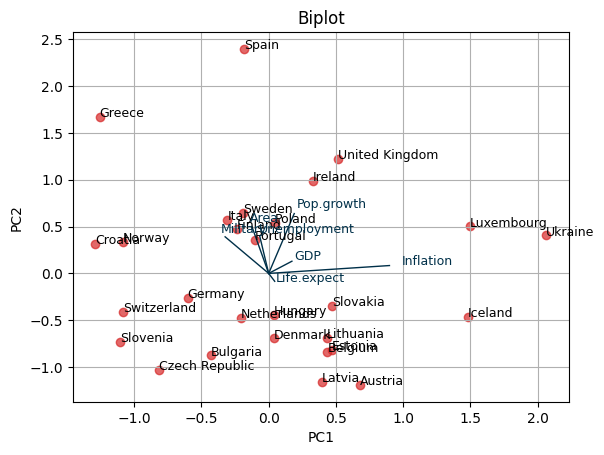

In [58]:
biplot(pcsDataset, dataset.columns[1:].to_numpy())

En base al Biplot, se puede concluir que:

* En Ucrania y Luxemburgo, la variable Inflación tiene mucho peso.

* España es el país que por diferencia más influye la superficie de su territorio.

* En Reino Unido e Irlanda, el crecimiento poblacional tienen más peso.

* A mayor gasto militar, menor expectativa de vida.

* Hay algunos _clusters_ que se pueden identificar:

    * Italia, Finalandia, Polonia, Suecia y Portugal
    * Croacia y Noruega
    * Eslovaquia, Lituania, Estonia, Bélgica, Lavtia y Austia
    * Hungría, Dinamarca y Holanda
    * Alemania, Suiza


## Análisis de Componentes Principales (PCA) con SKLearn

En vez de realizar los cálculos manualmente, se puede utilizar la librería `sklearn` para realizar el análisis de componentes principales.

In [62]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(standarizedDataset.select_dtypes(include='number').values)

array([[-0.1248739 ,  0.50050586, -0.40651815,  0.48287333, -0.18811162,
         0.47570355, -0.27165582],
       [-0.1728722 , -0.13013955, -0.36965724,  0.2652478 ,  0.65826689,
         0.08262198,  0.55320371]])

Luego, podemos armar un dataset similar al utilizado en el análisis manual y comparar los resultados.

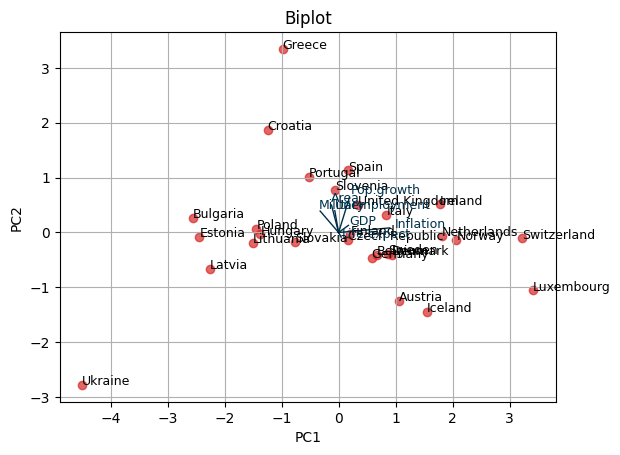

In [65]:
countries = dataset['Country']
countryData = standarizedDataset.select_dtypes(include='number').values
pcsDataset = pd.DataFrame({
    'Country': countries,
    'PC1': np.dot(countryData, pca.components_[0]),
    'PC2': np.dot(countryData, pca.components_[1]),
})

biplot(pcsDataset, dataset.columns[1:].to_numpy())